## 1: Introduction
So far, we have learned about decision trees, and looked at ways to reduce overfitting. The most powerful method to reduce decision tree overfitting is called the random forest algorithm. In this notebook, we'll learn how to construct and apply random forests.

We've been using the dataset, Carseats.csv, in this example. The data contains sales information about car seat sales in 400 stores. 

## 2: Ensemble Models
A random forest is a kind of **ensemble model**. Ensembles combine the predictions of multiple models to create a more accurate final prediction. We'll make a simple ensemble to see how it works.

We'll create two decision trees with slightly different parameters:

one with min_samples_leaf set to 2
one with max_depth set to 5
and check their accuracy separately. In the next screen, we'll combine their predictions and compare the combined accuracy with either tree's accuracy.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

In [2]:
# Instructions
'''
- Fit both clf and clf2 to the data.
- Make predictions on the test set predictors (test[columns]) using both clf and clf2.
'''

df3 = pd.read_csv('Data/Carseats.csv').dropna()
df3.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### Qualitative Predictors
The Carseats data includes qualitative predictors such as Shelveloc, an indicator of the quality of the shelving location—that is, the space within a store in which the car seat is displayed—at each location. The predictor Shelveloc takes on three possible values, Bad, Medium, and Good.  We will create a ShelveLocGood dummy variable that takes on a value of 1 if the shelving location is good, and 0 otherwise. We will also create a ShelveLocMedium dummy variable that equals 1 if the shelving location is medium, and 0 otherwise. A bad shelving location corresponds to a zero for each of the two dummy variables.

In [3]:
# convert sales to binary
df3['HighSales'] = df3.Sales.map(lambda x: 1 if x>8 else 0)

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})

# convert categorical variables to dummy variables
ShelveLoc = pd.get_dummies(df3['ShelveLoc'])

# Join the dummy variables to the main dataframe
df3_new = pd.concat([df3, ShelveLoc], axis=1)

df3_new.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,HighSales,Bad,Good,Medium
0,1,9.50,138,73,11,276,120,Bad,42,17,1,1,1,1,0,0
1,2,11.22,111,48,16,260,83,Good,65,10,1,1,1,0,1,0
2,3,10.06,113,35,10,269,80,Medium,59,12,1,1,1,0,0,1
3,4,7.40,117,100,4,466,97,Medium,55,14,1,1,0,0,0,1
4,5,4.15,141,64,3,340,128,Bad,38,13,1,0,0,1,0,0


In [4]:
X = df3_new.drop(['Sales', 'HighSales', 'ShelveLoc', 'Bad', 'Unnamed: 0'], axis=1)
y = df3_new.HighSales

x_columns = X.columns
print(x_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(X_train, y_train)

clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

predictions = clf2.predict(X_test)
print(accuracy_score(y_test, predictions))

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'Urban', 'US', 'Good', 'Medium'],
      dtype='object')
0.71
0.67


C:\Users\pzx0002\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 3: Combining Our Predictions
When we have multiple classifiers making predictions, we can treat each set of predictions as a column in a matrix. 

Here's an example where we have Decision Tree 1 (DT1), Decision Tree 2 (DT2), and DT3:

DT1  |  DT2 | DT3
--- | --- | --- 
0 | 1 | 0
1 | 1 | 1
0 | 0 | 1
1 | 0 | 0

When we add more models to our ensemble, we just add more columns to the combined predictions. Ultimately, we don't want this matrix, though -- we want one prediction per row in the training data. To do this, we'll need to create rules to turn each row of our matrix of predictions into a single number.

We want to create a Final Prediction vector:

DT1  |   DT2  |  DT3  |  Final Prediction
--- | --- | --- 
0    |   1  |    0   |   0
1   |    1  |    1   |   1
0   |    0    |  1  |    0
1  |     0   |   0  |    0

There are many ways to get from the output of multiple models to a final vector of predictions. One method is **majority voting**, where each classifier gets a "vote", and the most commonly voted value for each row wins. This only works if there are more than 2 classifiers (and ideally an odd number so we don't have to write a rule to break ties). Majority voting is what we applied in the example above.

Since in the last screen we only had two classifiers, we'll have to use a different method to combine predictions. We'll take the mean of all the items in a row. Right now, we're using the predict method, which returns either 0 or 1. predict returns something like this:

0
1
0
1


We can instead use the predict_proba method, which will predict a probability from 0 to 1 that a given class is the right one for a row. Since 0 and 1 are our two classes, we'll get a matrix with as many rows as the income dataframe and 2 columns. predict_proba will return something like this:


0  |  1
--- | --- 
.7  | .3
.2  | .8
.1  | .9


Each row will correspond to a prediction. The first column is the probability that the prediction is a 0, the second column is the probability that the prediction is a 1. Each row adds up to 1.

If we just take the second column, we get the average value that the classifier would predict for that row. If there's a .9 probability that the correct classification is 1, we can use the .9 as the value the classifier is predicting. This will give us a continuous output in a single vector instead of just 0 or 1.

We can then add all of the vectors we get through this method together and divide by the number of vectors to get the mean prediction by all the members of the ensemble. We can then round off to get 0 or 1 predictions.

If we use the predict_proba method on both classifiers from the last screen to generate probabilities, take the mean for each row, and then round the results, we'll get ensemble predictions.

In [5]:
'''
<Instruction>
Add predictions and predictions2, then divide by 2 to get the mean.
Use numpy.round to round all of the resulting predictions.
Print the resulting AUC score between the actual values and the predictions.
'''

predictions = clf.predict_proba(X_test)[:,1]
predictions2 = clf2.predict_proba(X_test)[:,1]
combined = (predictions + predictions2) / 2
rounded = np.round(combined)

print(accuracy_score(y_test, rounded))

0.73


## 4: Why Ensembling Works
As we can see from the previous screen, the combined predictions of the two trees had a higher AUC than either tree:

settings|test AUC
--- | --- 
min_samples_leaf: 2|0.71
max_depth: 5|0.67
combined predictions|0.73


To intuitively understand why this makes sense, think about two people at the same talent level. One learned programming in college. The other learned on their own.

If you give both of them a project, since they both have different knowledge and experience, they'll both approach it in slightly different ways. They may both produce code that achieves the same result, but one may run faster in certain areas. The other may have a better interface. Even though both of them have about the same talent level, because they approach the problem differently, their solutions are stronger in different areas.

If we combine the best parts of both of their projects, we'll end up with a stronger combined project.

Ensembling is the exact same. Both models are approaching the problem slightly differently, and building a different tree because we used different parameters for each. Each tree makes different predictions in different areas. Even though both trees have about the same accuracy, when we combine them, the result is stronger because it leverages the strengths of both approaches.

The more "diverse", or dissimilar, the models used to construct an ensemble, the stronger the combined predictions will be (assuming that all models have about the same accuracy). Ensembling a decision tree and a logistic regression model, which use very different approaches to arrive at their answers, will result in stronger predictions than ensembling two decision trees with similar parameters.

On the other side, if the models you ensemble are very similar in how they make predictions, you'll get a negligible boost from ensembling.

Ensembling models with very different accuracies will not generally improve your accuracy. Ensembling a model with a .75 AUC and a model with a .85 AUC on a test set will usually result in an AUC somewhere in between the two original values. There's a way around this which we'll discuss later on, called weighting.

## 5: Bagging
A random forest is an ensemble of decision trees. If we don't make any modifications to the trees and follow the same building algorithm, each tree will be the exact same, so we'll get no boost when we ensemble them. In order to make ensembling effective, we have to introduce variation into each individual decision tree model.

If we introduce variation, each tree will be be constructed slightly differently, and therefore will make different predictions. This variation is why the word "random" is in "random forest".

There are two main ways to introduce variation in a random forest -- bagging and random feature subsets. We'll dive into bagging first.

In a random forest, each tree is trained on a random sample of the data, or a "bag". This sampling is performed with replacement. When we sample with replacement, after we select a row from the data we're sampling, we put the row back in the data so it can be picked again. Some rows from the original data may appear in the "bag" multiple times.

In [6]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# we can achieve the above two tasks using the following codes
# Bagging: using all features
rfc1 = RandomForestClassifier(max_features=11, random_state=1)
rfc1.fit(X_train, y_train)
pred1 = rfc1.predict(X_test)
print(accuracy_score(y_test, pred1))

0.74


## 6: Selecting Random Features
With the bagging example from the previous screen, we gained some accuracy over a single decision tree. We achieved an Accuracy score of around 0.74 with bagging.

settings|test AUC
--- | --- 
min_samples_leaf: 2|0.71
max_depth: 5|0.67
combined predictions|0.73
min_samples_leaf: 2, with bagging|0.74

In this section, we'll only evaluate a constrained set of features, selected randomly. This introduces variation into the trees, and makes for more powerful ensembles.

We can also repeat our random subset selection process in scikit-learn. We just set the splitter parameter on DecisionTreeClassifier to "random", and the max_features parameter to "auto". If we have N columns, this will pick a subset of features of size sqrt(N).

In [7]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# play around with the setting for max_features
for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train, y_train)
    pred2 = rfc2.predict(X_test)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))

Accuracy for 1 feature(s) equals 0.73
Accuracy for 2 feature(s) equals 0.765
Accuracy for 3 feature(s) equals 0.74
Accuracy for 4 feature(s) equals 0.695
Accuracy for 5 feature(s) equals 0.74
Accuracy for 6 feature(s) equals 0.705
Accuracy for 7 feature(s) equals 0.73
Accuracy for 8 feature(s) equals 0.745
Accuracy for 9 feature(s) equals 0.755
Accuracy for 10 feature(s) equals 0.73


In [8]:
# View a list of the features and their importance scores
list(zip(X_train, rfc1.feature_importances_))

[('CompPrice', 0.15141418751502395),
 ('Income', 0.12372719124461444),
 ('Advertising', 0.10860891444101148),
 ('Population', 0.08540184584772219),
 ('Price', 0.3003808724403305),
 ('Age', 0.13501976621014836),
 ('Education', 0.030790401661152867),
 ('Urban', 0.0014078062858550661),
 ('US', 0.0054020015121781315),
 ('Good', 0.048464509864021586),
 ('Medium', 0.009382502977941352)]

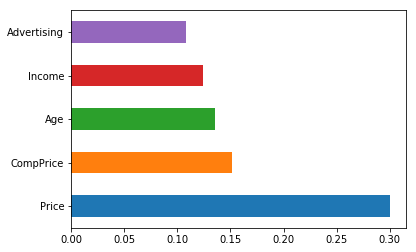

In [9]:
# We can also plot the important features

feat_importances = pd.Series(rfc1.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

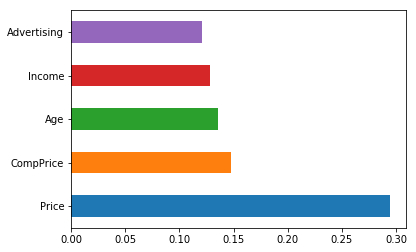

In [10]:
feat_importances = pd.Series(rfc2.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

## 7: When To Use Random Forests

** Putting It All Together:**

settings|test AUC
--- | --- 
min_samples_leaf: 2|0.71
max_depth: 5|0.67
combined predictions|0.73
min_samples_leaf: 2, with bagging|0.74
min_samples_leaf: 2, with bagging and random subsets|0.77


The random forest algorithm is incredibly powerful, but isn't applicable to all tasks. The main strengths of a random forest are:

Very accurate predictions -- Random forests achieve near state of the art performance on many machine learning tasks. Along with neural networks and gradient boosted trees, they are typically one of the top performing algorithms.
Resistance to overfitting -- due to how they're constructed, random forests are fairly resistant to overfitting. Parameters like max_depth still have to be set and tweaked, though.

The main weaknesses are:
Hard to interpret -- because we've averaging the results of many trees, it can be hard to figure out why a random forest is making predictions the way it is.
Longer creation time -- making two trees takes twice as long as making one, 3 takes three times as long, and so on. Luckily, we can exploit multicore processors to parallelize tree construction. 

Given these tradeoffs, it makes sense to use random forests in situations where accuracy is of the utmost importance, and being able to interpret or explain the decisions the model is making isn't key. In cases where time is of the essence, or interpretability is important, a single decision tree may be a better choice.

### Future Reading


#### Introducing Partial Dependence Plots: Python PDPbox

When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction. 

https://towardsdatascience.com/introducing-pdpbox-2aa820afd312
